In [1]:
#Community imports
import os
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from datetime import datetime
import geopandas as gpd

from shapely.geometry import MultiPolygon, MultiPoint, Point
import shapely.speedups
shapely.speedups.enable()

#pyWavlet imports
from snowradar import snowradar
from atm import atm
import picklayers

#Constants
base_crs= {'init': 'epsg:4326'}

C:\Users\kingj\AppData\Local\Continuum\anaconda3\envs\wavelet\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Load the SR meta data

In [2]:
radar_dir= "./data/eureka/sr"
radar_path = []
radar_file = []
for file in os.listdir(radar_dir):
    if file.endswith(".mat"):
        radar_path.append(os.path.join(radar_dir, file))
        radar_file.append(file)
radar_meta = [snowradar(fp, l_case='meta') for fp in radar_path]
radar_mpoly = MultiPolygon([x.poly for x in radar_meta])

In [3]:
sr_meta_df = gpd.pd.DataFrame([x.as_dict() for x in radar_meta])
sr_meta_df = gpd.GeoDataFrame(sr_meta_df, crs=base_crs, geometry=sr_meta_df.poly)
sr_meta_df = sr_meta_df.drop(['poly'], axis=1)
sr_meta_df['atm_idx'] = None

### Load the ATM meta data

In [5]:
atm_dir= "./data/eureka/atm"
atm_path = []
atm_file = []
for file in os.listdir(atm_dir):
    if file.endswith(".h5"):
        atm_path.append(os.path.join(atm_dir, file))
        atm_file.append(file)
atm_meta = [atm(fp, l_case='meta') for fp in atm_path]
atm_mpoly = MultiPolygon([x.poly for x in atm_meta])

In [6]:
atm_meta_df = gpd.pd.DataFrame([x.as_dict() for x in atm_meta])
atm_meta_df = gpd.GeoDataFrame(atm_meta_df, crs=base_crs, geometry=atm_meta_df.poly)
atm_meta_df = atm_meta_df.drop(['poly'], axis=1)

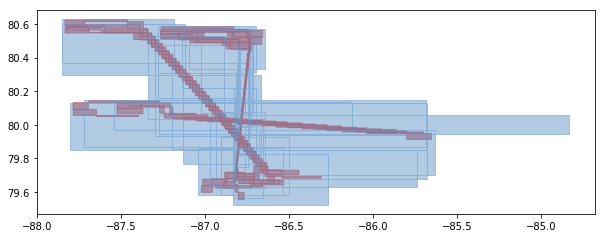

In [7]:
BLUE = '#6699cc'
RED = '#cc0a0a'
fig, ax = plt.subplots(figsize=(10,10))
ax = fig.gca() 
ax.add_patch(PolygonPatch(radar_mpoly, fc=RED, ec=RED, alpha=0.5, zorder=2 ))
ax.add_patch(PolygonPatch(atm_mpoly, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
ax.axis('scaled')
plt.show()

## Process SR

In [8]:
for sr_index, sr_row in sr_meta_df.iterrows():
    time_diff = sr_row['tstart']-atm_meta_df['tstart']
    time_diff = time_diff[time_diff>0]
    if not time_diff.empty:
        t_idx = time_diff[time_diff>0].idxmin()
        if (sr_row['tend']>atm_meta_df.loc[t_idx]['tend']):
            #These are cases where the file crosses two ATM files
            #TODO load two atm files
            continue
        sr_meta_df.loc[sr_index,('atm_idx')] = t_idx

In [27]:
atmi = 11
atm_cur = atm(atm_meta_df.loc[atmi,('fpath')], 'full')

atm_df = gpd.pd.DataFrame({ "time": atm_cur.time_utc,
                          "lat":atm_cur.lat,
                          "lon":atm_cur.lon, 
                          "data":atm_cur.elv})
#atm_geom = [Point(xy) for xy in zip(atm_df.lon, atm_df.lat)]
#atm_df = atm_df.drop(['lat', 'lon'], axis=1)
#atm_df = gpd.GeoDataFrame(atm_df, crs=base_crs, geometry=atm_geom)
#atm_df = atm_df.to_crs({'init': 'epsg:3413'})



In [26]:
atm_cur.time_utc

array([1.46107569e+09, 1.46107569e+09, 1.46107569e+09, ...,
       1.46107616e+09, 1.46107616e+09, 1.46107616e+09])

In [24]:
atm_geom = [Point(xy) for xy in zip(atm_df.lon, atm_df.lat)]

In [15]:
pd.DataFrame([[atm_cur.lat,atm_cur.lat,atm_cur.lat]],columns=['lat','lon','phi'])

,lat,lon,phi
0,"[80.47666, 80.476636, 80.476611, 80.476584, 80...","[80.47666, 80.476636, 80.476611, 80.476584, 80...","[80.47666, 80.476636, 80.476611, 80.476584, 80..."


In [126]:
spatial_index = atm_df.sindex

In [131]:
possible_matches_index = list(spatial_index.intersection(sr_df.loc[0].buff.bounds))
possible_matches = atm_df.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(sr_df.loc[0].buff)]

In [ ]:
spatial_index = gdf.sindex
possible_matches_index = list(spatial_index.intersection(polygon.bounds))
possible_matches = gdf.iloc[possible_matches_index]
precise_matches = possible_matches[possible_matches.intersects(polygon)]



In [ ]:
sr_paths = sr_meta_df.loc[sr_meta_df.index[sr_meta_df['atm_idx'] == atmi],('fpath')]
sr_data = [snowradar(fp, l_case='full') for fp in sr_paths]

In [132]:
precise_matches 

,data,geometry
index_left,,
90099,6.846,POINT (-697982.4641415835 -768110.641865588)
83813,7.013,POINT (-697978.8499815011 -768109.3580818115)
83958,6.782,POINT (-697986.8944777561 -768109.2683757626)
90101,6.974,POINT (-697974.4953800302 -768114.9359546093)
90248,6.912,POINT (-697988.0096210157 -768114.8859804304)
83659,7.076,POINT (-697962.1585761788 -768114.8000084534)
83956,6.903,POINT (-697982.5469785234 -768114.6924959577)
84090,6.973,POINT (-697990.5449741627 -768114.4976982336)
83811,7.090,POINT (-697974.042722233 -768114.1684559271)


In [119]:
radar_cur = sr_data[0]
sr_df = gpd.pd.DataFrame({"lat":radar_cur.lat,
                          "lon":radar_cur.lon})
    
sr_geom = [Point(xy) for xy in zip(radar_cur.lon, radar_cur.lat)]
sr_df = gpd.GeoDataFrame(sr_df, crs=base_crs, geometry=sr_geom)
sr_df = sr_df.to_crs({'init': 'epsg:3413'})
sr_df['buff'] = sr_df.geometry.buffer(50)

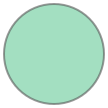

In [127]:
sr_df.loc[0].buff

In [124]:
zips_and_states = gpd.sjoin(atm_df, sr_df, op='within')

In [102]:
#sr_df.geometry.buffer(100)
#subset = points[points.within(polygon)]

atm_mask = atm_df.within(sr_df.geometry.buffer(100)[0])
atm_sub = atm_df.loc[atm_mask]

In [125]:
zips_and_states 

,data,geometry,index_right,lat,lon,buff


In [59]:
density_snow = 0.300 #Density of snow on sea ice; See Alexandrov et al., 2010, The Cryosphere
perm_snow = (1 + 0.51 * density_snow) ** 3  #Density to permitivity
n_snow = np.sqrt(perm_snow) #Permitivity to refractive index
c = 299792458 #Vacuum speed of light

In [63]:
sr_data[0].calcpulsewidth()
print(sr_data[0].epw)
print(sr_data[0].n2n)
l_as,l_si = np.apply_along_axis(picklayers.picklayers, 0, sr_data[0].data_radar,sr_data[0].n2n,sr_data[0].dfr,n_snow)

0.07570516616161617
0.20186025505333335


Mean snow depth (m): 0.27456279558649826


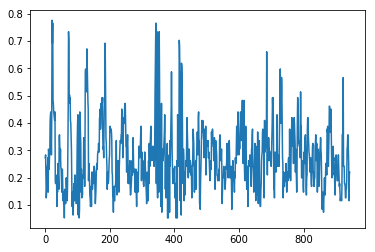

In [65]:
snow_depth = (l_si - l_as) * sr_data[0].dfr / n_snow
print("Mean snow depth (m):", np.mean(snow_depth))
plt.plot(snow_depth);

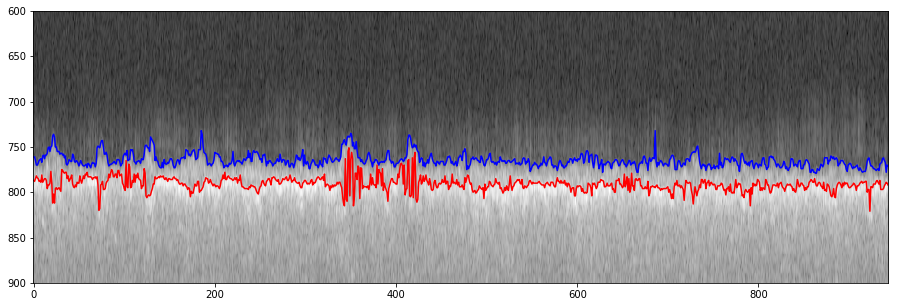

In [69]:
fig, ax = plt.subplots(figsize=(25,5))
ax.imshow(10 * np.log10(sr_data[0].data_radar), interpolation='nearest', cmap="gist_gray")
ax.plot(l_si, color='r')
ax.plot(l_as, color='b')
ax.set_ylim([900, 600])
plt.show()

In [25]:
atm_cur = atm(atm_meta_df.loc[atm_idx]['fpath'], 'full')
atm_df = gpd.pd.DataFrame({"lat":atm_cur.lat,
                          "lon":atm_cur.lon, 
                          "data":atm_cur.elv})
atm_geom = [Point(xy) for xy in zip(atm_df.lon, atm_df.lat)]
atm_df = atm_df.drop(['lat', 'lon'], axis=1)
atm_df = gpd.GeoDataFrame(atm_df, crs=crs, geometry=atm_geom)


#atm_mask = atm_cur.within(radar_cur.poly)
#atm_sub = atm_df.loc[atm_mask]

NameError: name 'crs' is not defined

'./data/eureka/atm\\ILATM1B_20160419_164534.ATM5AT2.h5'

### Process files

In [19]:
i = 122
radar_cur = snowradar(radar_meta[i].file_path, 'full')
radar_epoch = datetime.utcfromtimestamp(radar_cur.utc_time[0])
print(radar_epoch)

2016-04-19 14:27:46.143111


In [20]:
time_diff = np.asarray([(radar_epoch - x.file_epoch).total_seconds() for x in atm_meta])
atm_idx = time_diff[time_diff>0].argmin()
atm_meta[atm_idx].file_epoch

datetime.datetime(2016, 4, 19, 14, 21, 43)

In [21]:
atm_cur = atm(atm_meta[atm_idx].file_path, 'full')

In [22]:
atm_df = gpd.pd.DataFrame({"lat":atm_cur.lat,
                          "lon":atm_cur.lon, 
                          "data":atm_cur.elv})
atm_geom = [Point(xy) for xy in zip(atm_df.lon, atm_df.lat)]
atm_df = atm_df.drop(['lat', 'lon'], axis=1)
crs = {'init': 'epsg:4326'}
atm_df = gpd.GeoDataFrame(atm_df, crs=crs, geometry=atm_geom)

In [28]:
atm_mask = atm_df.within(radar_cur.poly)
atm_sub = atm_df.loc[atm_mask]

In [105]:
atm_sub

,data,geometry
82612,6.998,POINT (-697918.8367825453 -768084.1731249467)
82613,6.950,POINT (-697922.3025521486 -768083.3815508591)
82614,6.975,POINT (-697925.6618625454 -768082.3919979376)
82615,6.988,POINT (-697928.9013065584 -768081.2166481386)
82616,6.917,POINT (-697932.0208825682 -768079.8555024663)
82617,7.024,POINT (-697935.0939283932 -768078.3892721296)
82618,7.244,POINT (-697937.9737636581 -768076.6565376091)
82619,7.055,POINT (-697940.8070658457 -768074.8187201081)
82620,6.979,POINT (-697943.5070883335 -768072.8072919761)
82621,7.025,POINT (-697946.0872348137 -768070.610073038)


In [29]:
 sr_df = gpd.pd.DataFrame({"lat":radar_cur.lat,
                          "lon":radar_cur.lon})
    
sr_geom = [Point(xy) for xy in zip(radar_cur.lon, radar_cur.lat)]
#sr_df = sr_df.drop(['lat', 'lon'], axis=1)
crs = {'init': 'epsg:4326'}
sr_df = gpd.GeoDataFrame(sr_df, crs=crs, geometry=sr_geom)

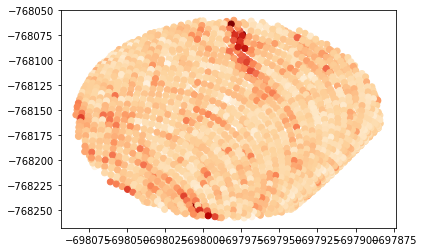

In [114]:
fig, ax = plt.subplots()
#atm_sub.plot(ax=ax, color='gold', markersize=0.5);
atm_sub.plot(ax=ax, column='data', cmap='OrRd')
#sr_df.plot(ax=ax, color='black', markersize=0.5);

In [109]:
sr_df.loc[0]

lat                                               80.4401
lon                                              -87.2597
geometry    POINT (-697983.4723725519 -768158.9649441843)
Name: 0, dtype: object

In [113]:
sr_df

,lat,lon,geometry
0,80.440140,-87.259684,POINT (-697983.4723725519 -768158.9649441843)
1,80.440093,-87.259644,POINT (-697986.3787155293 -768163.2578968086)
2,80.440046,-87.259603,POINT (-697989.2849416496 -768167.550913993)
3,80.439999,-87.259562,POINT (-697992.1909919344 -768171.8437585076)
4,80.439952,-87.259522,POINT (-697995.0970847509 -768176.1365399347)
5,80.439905,-87.259481,POINT (-697998.003400423 -768180.4296124758)
6,80.439858,-87.259440,POINT (-698000.9097446955 -768184.7224653363)
7,80.439810,-87.259400,POINT (-698003.8162560861 -768189.0152488471)
8,80.439763,-87.259359,POINT (-698006.7227208421 -768193.3077834812)
9,80.439716,-87.259319,POINT (-698009.6293567859 -768197.6003079541)
